# 04_train-cloud.ipynb

**Cloud Training with SageMaker’s XGBoost Estimator**

Using the built‑in SageMaker XGBoost container, this notebook launches a managed training job on `ml.m5.xlarge` (or your chosen instance), monitors training/validation metrics, then downloads and extracts the resulting `model.tar.gz` for in‑notebook inference and evaluation.

In [3]:
import sagemaker
from sagemaker.xgboost import XGBoost
from sagemaker.inputs import TrainingInput

sess   = sagemaker.Session()
role   = sagemaker.get_execution_role()
bucket = sess.default_bucket()
prefix = "recs"

xgb_est = XGBoost(
    entry_point="train.py",
    framework_version="1.7-1",
    instance_type="ml.m5.xlarge",   # ← run in AWS, not locally
    instance_count=1,
    role=role,
    output_path=f"s3://{bucket}/{prefix}/output",
    hyperparameters={
        "objective":             "reg:squarederror",
        "max_depth":             6,
        "eta":                   0.1,
        "subsample":             0.8,
        "colsample_bytree":      0.8,
        "num_round":             500,
        "early_stopping_rounds": 25,
    },
)

# Only one channel: everything lives under "train"
train_s3 = f"s3://{bucket}/{prefix}/train"
xgb_est.fit({"train": TrainingInput(train_s3, content_type="parquet")})

[04/22/25 19:33:59] INFO     Ignoring unnecessary Python version: py3.                            ]8;id=795409;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=700505;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py#603\603]8;;\

                    INFO     Ignoring unnecessary instance type: ml.m5.xlarge.                    ]8;id=150272;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=350506;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=249350;file:///opt/conda/lib/python3.12/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=720104;file:///opt/conda/lib/python3.12/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=887749;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=17006;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#1042\1042]8;;\
                             sagemaker-xgboost-2025-04-22-19-33-59-505                                             

2025-04-22 19:34:00 Starting - Starting the training job..

In [4]:
# 1. Grab the job name
job_name = xgb_est.latest_training_job.name

# 2. Wait for it to finish
sess = sagemaker.Session()
sess.wait_for_job(job_name)   # this will block until it's InService or Failed

# 3. Or poll its status manually
sm = sess.sagemaker_client
desc = sm.describe_training_job(TrainingJobName=job_name)
print("Status:", desc["TrainingJobStatus"])
# Possible values: InProgress, Completed, Failed, Stopped


2025-04-22 19:37:51 Starting - Preparing the instances for training
2025-04-22 19:37:51 Downloading - Downloading the training image
2025-04-22 19:37:51 Training - Training image download completed. Training in progress.
2025-04-22 19:37:51 Uploading - Uploading generated training model..
2025-04-22 19:38:05 Completed - Training job completed
Status: Completed


In [6]:
import os
import boto3
import tarfile
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sagemaker import Session

sess   = Session()
bucket = sess.default_bucket()
prefix = "recs"

# 1. Where SageMaker saved your model
model_s3_uri = xgb_est.model_data
# e.g. "s3://<bucket>/recs/output/sagemaker-xgboost-.../output/model.tar.gz"

# 2. Download it to local disk
parsed = model_s3_uri.replace("s3://", "").split("/", 1)
s3_bucket, s3_key = parsed[0], parsed[1]
boto3.client("s3").download_file(s3_bucket, s3_key, "model.tar.gz")

# 3. Extract the Booster file (usually "model.bst")
with tarfile.open("model.tar.gz") as tar:
    tar.extractall()

# 4. Load the Booster into XGBoost
bst = xgb.Booster()
bst.load_model("model.bst")

# 5. Read your test set from S3
X_test = pd.read_parquet(f"s3://{bucket}/{prefix}/test/X_test.parquet")
y_test = pd.read_parquet(f"s3://{bucket}/{prefix}/test/y_test.parquet").squeeze()

# 6. Predict (remember you trained on log1p!)
dtest     = xgb.DMatrix(X_test)
y_pred_log = bst.predict(dtest)
y_pred     = np.expm1(y_pred_log)

# 7. Compute RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"✅ In‑notebook RMSE on test set: {rmse:.2f}")

/tmp/ipykernel_11324/2154425895.py:25: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


✅ In‑notebook RMSE on test set: 1458.73


/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [10]:
%pip install shap

  Using cached shap-0.47.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (25 kB)
  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
Using cached shap-0.47.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.0 MB)
Using cached slicer-0.0.8-py3-none-any.whl (15 kB)
Note: you may need to restart the kernel to use updated packages.


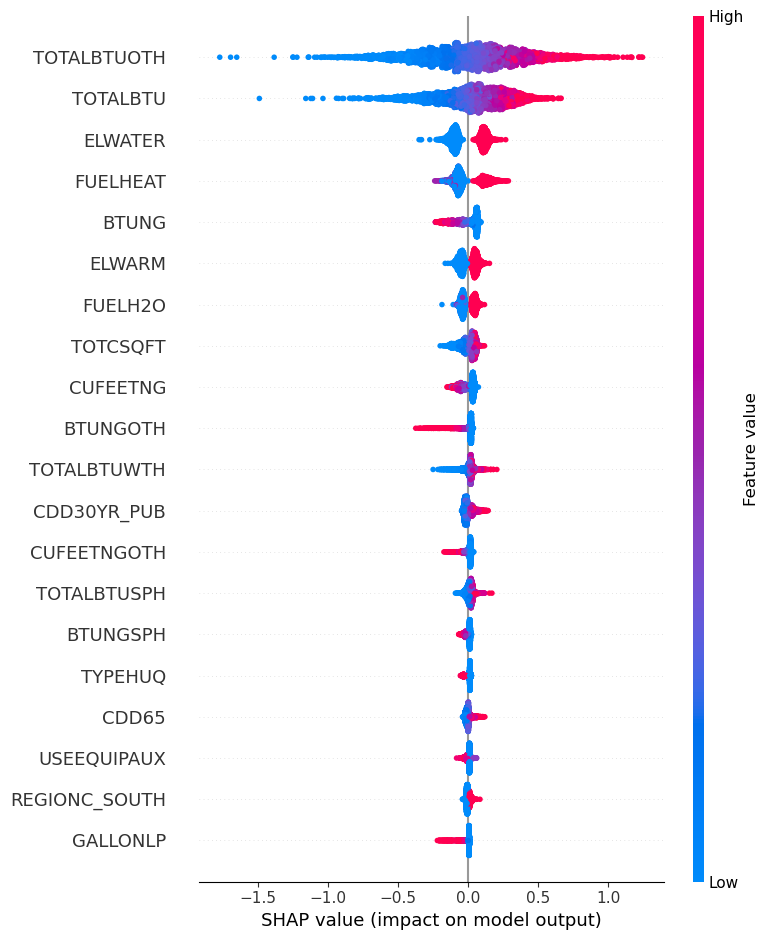

In [12]:
import shap

explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(dtest)
shap.summary_plot(shap_values, X_test)

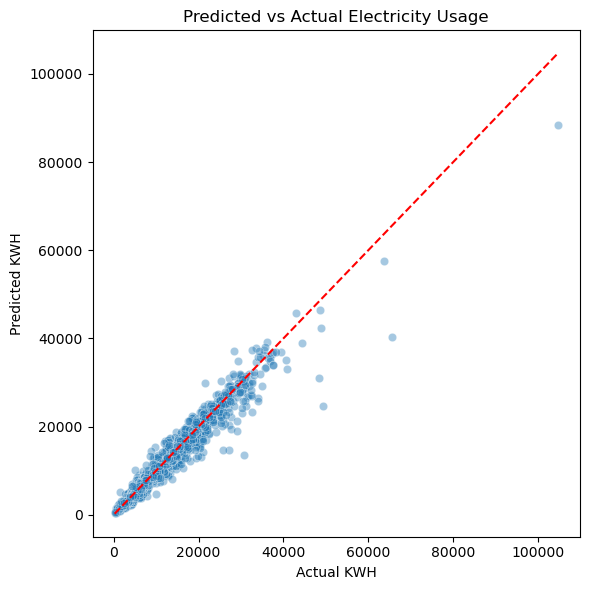

In [15]:
# 7. Plot predicted vs actual
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)
plt.xlabel("Actual KWH")
plt.ylabel("Predicted KWH")
plt.title("Predicted vs Actual Electricity Usage")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.tight_layout()
plt.show()